# Clustering My Most Played Spotify Songs

This notebook will be for creating a clustering model for my most played Spotify songs.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

In [2]:
df = pd.read_csv('FinalSongAnalysisMerged.csv')

In [3]:
df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,artistName,trackName
0,0.395,0.848,4,-7.285,0,0.0527,0.00126,0.000500,0.335,0.580,87.619,Kansas,Don't Open Your Eyes
1,0.599,0.846,5,-6.086,1,0.1980,0.05150,0.000012,0.748,0.875,108.207,Kansas,Stay out of Trouble
2,0.327,0.851,6,-7.656,0,0.0629,0.00206,0.003700,0.722,0.508,96.377,Kansas,Icarus - Borne on Wings of Steel
3,0.376,0.853,11,-6.698,0,0.3080,0.01870,0.024900,0.300,0.301,144.403,Kansas,How My Soul Cries Out for You
4,0.427,0.730,9,-6.173,0,0.0360,0.01800,0.000364,0.218,0.553,106.255,Kansas,Miracles out of Nowhere


### Review

As I saw in the previous notebook, there is not much correlation between any of the features. Additionally, most songs had very similar features, which is not surprising since it is my most played song.

### Feature Meanings

Danceability: From 0 to 1. How "easy" it is to dance to a song.

Energy: 0 to 1. Represents a perceptual measure of intensity and activity. Higher ---> more energy

Key: Major key of a track {0: C, 1: C#, 2:D, ..., 11: B}

Loudness: Overall loudness of a track in dB. Typically between -60 and 0 dB.

Mode: Major (1) or Minor (0)

Speechiness: 0 to 1. Detects the amount of speech compared to the amount of singing. Higher ---> more speech.

Acousticness: 0 to 1. Measures how acoustic vs. electric. Higher is more acoustic.

Instrumentalness: 0 to 1. The higher, the more likely it is instrumental (no vocals)

Liveness: 0 to 1. Higher means the track is more likely to be recorded live.

Valence: 0 to 1. Positiveness conveyed by a song. The higher the score, the more positive (happy, etc) it is.

Tempo: The quickness of a song. The higher, the more fast-paced.

### Acousticness

The acousticness for most of my songs is very low (almost zero), so I want to make a better visual to see if, at a smaller scale, there is a difference.

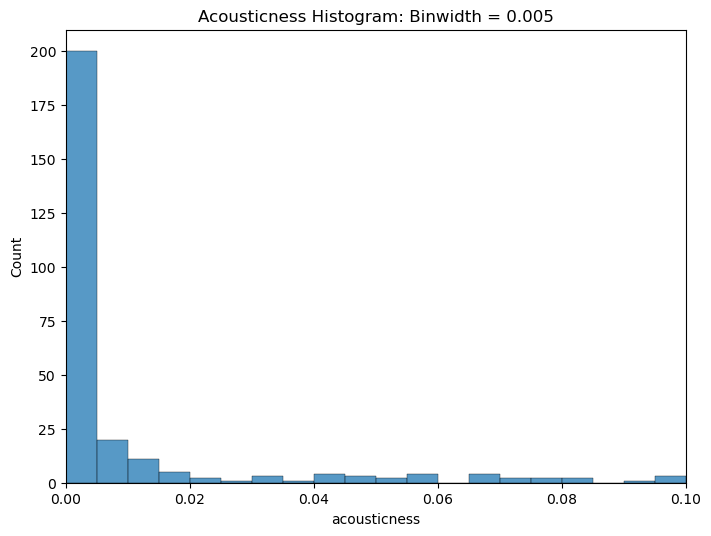

In [4]:
plt.figure(figsize=(8,6),dpi=100)

sns.histplot(data=df, x='acousticness', binwidth=0.005)

plt.title("Acousticness Histogram: Binwidth = 0.005")
plt.xlim(0, 0.1)
plt.show()

As we can see,  around 200 out of 294 songs in the dataset have acousticness between 0 and 0.005. Since the range of acousticness is 0 to 1, this shows that the acousticness feature of most of my songs is basically zero and there really is not much spread over a small range.

### Key and Mode

The main key of a song will often determine the "sound" of a song (not necessarily style), but this can be related to the mode of the song (whether it is in major or minor key).

I want to see if visualizing the keys split on the mode gives any indication of whether a song is in major or minor based on its main key.

In [5]:
df['mode'].value_counts() # value counts of mode for reference

1    192
0    102
Name: mode, dtype: int64

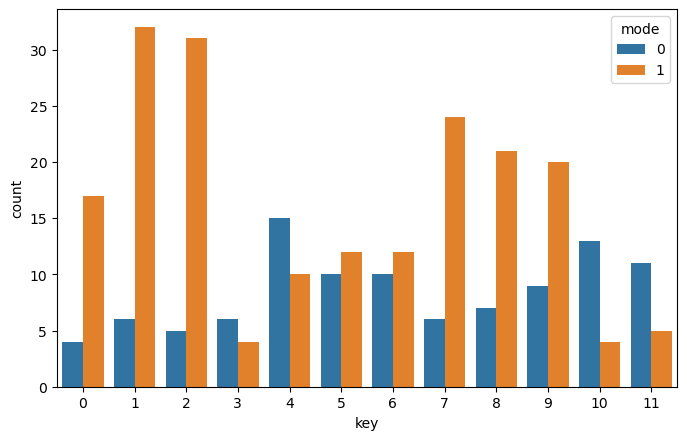

In [6]:
plt.figure(figsize=(8,5), dpi=100)

sns.countplot(data=df, x='key', hue='mode');

As we can see, if the main key of a song is in 0-2 or 7-9, then the song will more likely be played in a major key. However, the rest of the keys are very similar, with some having majority of minor key.

Of note is that there is roughly a 2 to 1 ratio overall of major to minor key, so this could indicate that, if the main key is 0-2 or 7-9 (especially 0-2), then there is a strong indication the song will be played in major.

### Model Creation

In [8]:
features_for_cluster = df.columns.drop(['artistName', 'trackName'])

X = df[features_for_cluster]

In [9]:
X.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.395,0.848,4,-7.285,0,0.0527,0.00126,0.000500,0.335,0.580,87.619
1,0.599,0.846,5,-6.086,1,0.1980,0.05150,0.000012,0.748,0.875,108.207
2,0.327,0.851,6,-7.656,0,0.0629,0.00206,0.003700,0.722,0.508,96.377
3,0.376,0.853,11,-6.698,0,0.3080,0.01870,0.024900,0.300,0.301,144.403
4,0.427,0.730,9,-6.173,0,0.0360,0.01800,0.000364,0.218,0.553,106.255


In [11]:
onehot = OneHotEncoder()
scaler = StandardScaler()

preprocessing = ColumnTransformer([
    ('nums', scaler, X.select_dtypes(include='float64').columns), # non-categorical numerical features
    ('cats', onehot, X.select_dtypes(include='int64').columns) # categorical numerical features
])

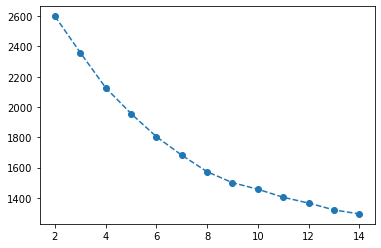

In [12]:
ssd = []

N = 15
for k in range(2, N):
    kmeans_pipeline = Pipeline([
        ('preprocessing', preprocessing),
        ('kmeans', KMeans(n_clusters=k))
    ])
    
    kmeans_pipeline.fit(X)
    
    inertia = kmeans_pipeline[1].inertia_
    ssd.append(inertia)
    

plt.plot(range(2,N), ssd, 'o--')

It looks like k=9 is a good choice, however because I know my top songs are all relatively similar overall (I mainly listen to music while exercising, and I like the same style), I will choose k=3.

I experimented with different values of k to see how the features would separate and k=3 did the best job grouping things in an interpretable way.

In [27]:
kmeans_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('kmeans', KMeans(n_clusters=3))
])

clusters = kmeans_pipeline.fit_predict(X)

cluster_centers = kmeans_pipeline[1].cluster_centers_

In [28]:
df['Cluster'] = clusters

df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,artistName,trackName,Cluster
0,0.395,0.848,4,-7.285,0,0.0527,0.00126,0.000500,0.335,0.580,87.619,Kansas,Don't Open Your Eyes,1
1,0.599,0.846,5,-6.086,1,0.1980,0.05150,0.000012,0.748,0.875,108.207,Kansas,Stay out of Trouble,1
2,0.327,0.851,6,-7.656,0,0.0629,0.00206,0.003700,0.722,0.508,96.377,Kansas,Icarus - Borne on Wings of Steel,1
3,0.376,0.853,11,-6.698,0,0.3080,0.01870,0.024900,0.300,0.301,144.403,Kansas,How My Soul Cries Out for You,0
4,0.427,0.730,9,-6.173,0,0.0360,0.01800,0.000364,0.218,0.553,106.255,Kansas,Miracles out of Nowhere,1


In [29]:
df.groupby('Cluster').mean().transpose()

Cluster,0,1,2
danceability,0.356684,0.503892,0.512119
energy,0.932821,0.917924,0.654324
key,5.294737,5.191083,4.880952
loudness,-4.209032,-4.808064,-9.699738
mode,0.684211,0.643312,0.619048
speechiness,0.125745,0.074063,0.065910
acousticness,0.008222,0.016041,0.147353
instrumentalness,0.046861,0.009975,0.053962
liveness,0.219961,0.219413,0.299933
valence,0.397991,0.544280,0.554667


In [30]:
df['Cluster'].value_counts()

1    157
0     95
2     42
Name: Cluster, dtype: int64

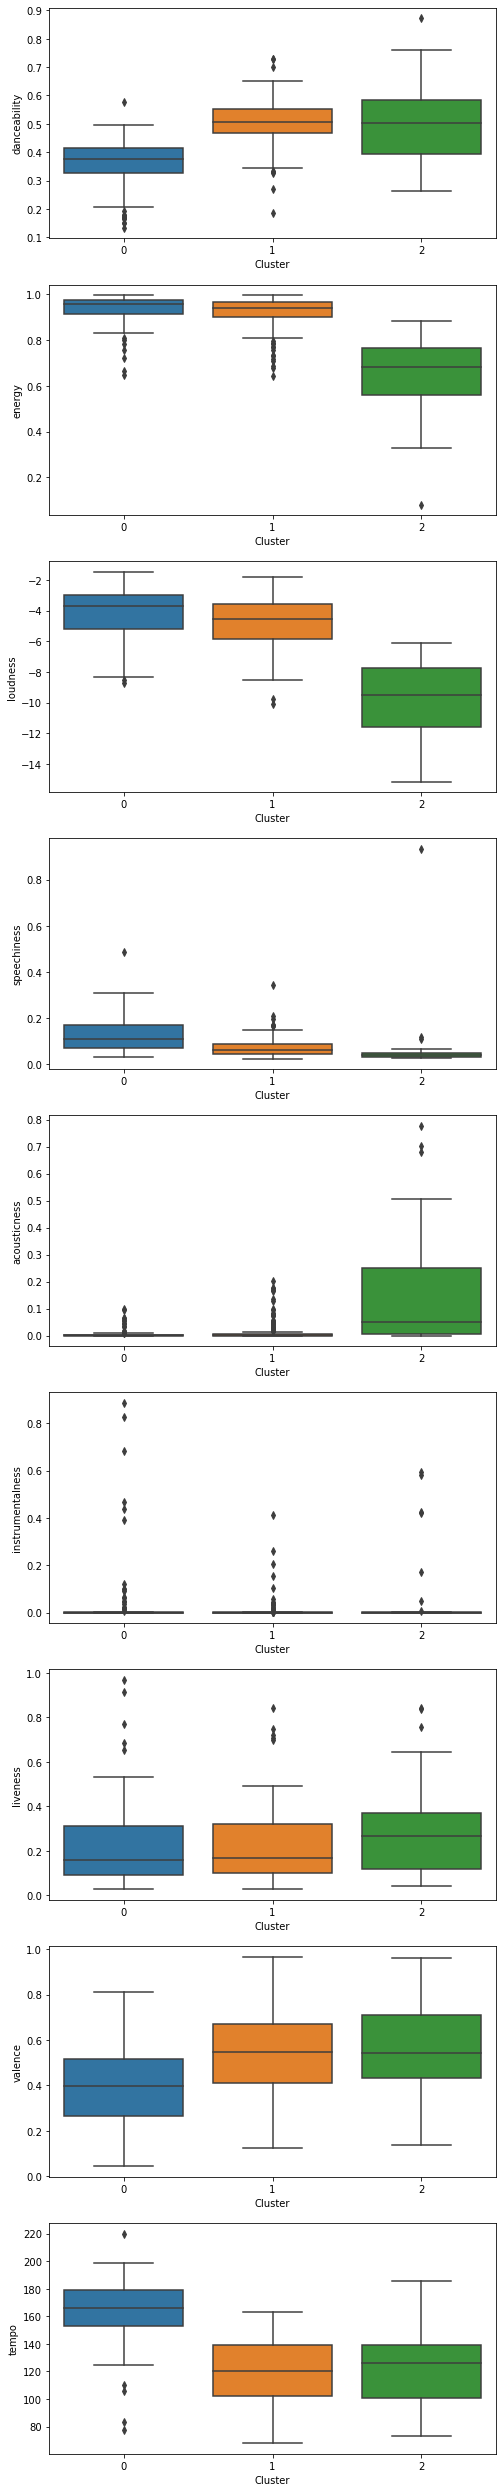

In [31]:
num_feats = df.select_dtypes(include='number').columns.drop(['Cluster', 'key', 'mode'])

N = len(num_feats)

fig, ax = plt.subplots(nrows=N, ncols=1, figsize=(8, 5*N))

for i in range(N):
    sns.boxplot(data=df, x='Cluster', y=num_feats[i], ax=ax[i])
    

plt.show()

We can see some direct separation with some of the features by cluster. 

Overall, most of the clusters are similar: Moderate danceability, high energy, high loudness, low speechiness, low acousticness, low instrumentalness, low liveness, moderate valence, high tempo.

Cluster 0: Lower danceability, higher speechiness, lower valence (although not much), higher tempo.

Cluster 1: Less danceability, higher tempo and higher speechiness.

Cluster 2: Lower energy, lower loudness, higher acousticness, 

### Conclusion

Overall, I am not surprised to see the overall statistics. Since all the songs are rather similar (high energy, tempo, etc), the clusters 0 and 1, which contained most of the songs, are very similar with the only difference being the tempo, danceability, and speechiness feature. I would propose the reason for this is a song with tempo very high (160 is very high), the singing can get a little bit on the speechy side, and it is also very hard to dance to extremely fast music. I find it interesting that the valence for cluster 0 as a separation, although small, from the other two clusters. It seems like valence should be, by definition, related more to the lyrics of the song, which this dataset does not account for.

Cluster 2's features tend to show a lower energy, less loud, and more acoustic type of song. These three features make sense to go together as loudness/energy are correlated, and naturally, acoustic-sounding songs would be less loud (at least in the "rock" genre). Noting that the size of cluster 2 is 42, this is the smallest cluster as well, which would indicate I do not listen to these types of songs as often.

Overall, I am not surprised by my findings as I typically listen to music while exercising, and I prefer faster-paced type music during this.